Row
    [0] Spacer(height=100, sizing_mode='fixed', width=50)
    [1] Column
        [0] PNG(str, width=1000)
        [1] Spacer(height=50, sizing_mode='fixed', width=50)
        [2] Row
            [0] Column
                [0] Markdown(str)
                [1] Select(name='Choose a complaint t..., options=['Apartment Construction/M...], value='Apartment Construction/Ma...)
            [1] ParamFunction(function)
            [2] Spacer(height=600, sizing_mode='fixed', width=10)
        [3] Row
            [0] Column
                [0] Markdown(str)
                [1] Select(name='Street Address', options=['209 West 102nd Street', ...], value='209 West 102nd Street')
            [1] ParamFunction(function)
        [4] Spacer(height=100, sizing_mode='fixed', width=50)
        [5] PNG(str, width=1000)
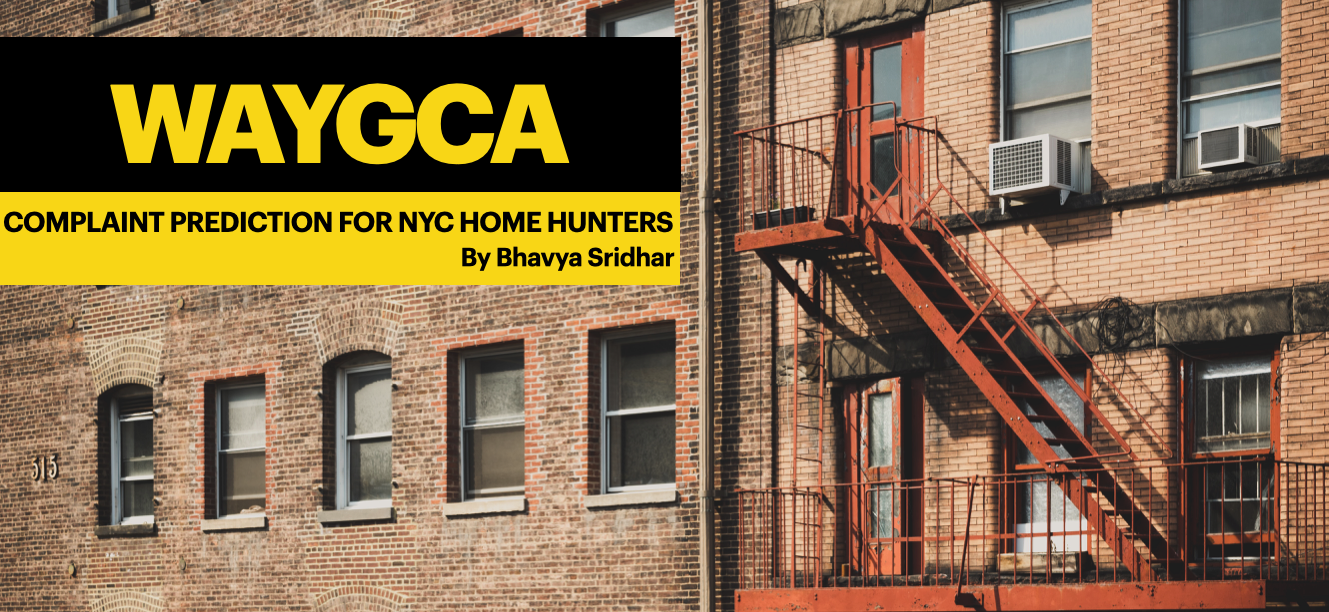
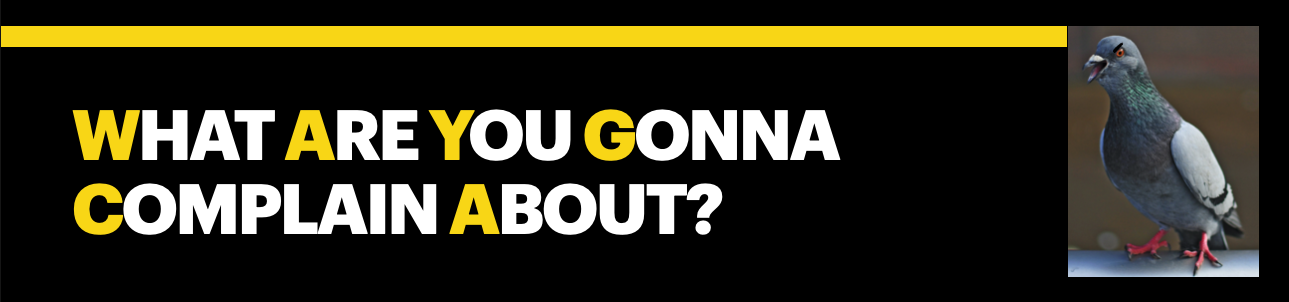

In [220]:
import dill
import panel as pn
import json
import altair as alt
import pandas as pd

with open('gdf_merged.dill', 'rb') as f:
    gdf_merged = dill.load(f)

variable_list = ['Apartment Construction/Maintenance', 'Building Maintenance',
                 'Heat/Hot Water/Electricity', 'Noise - Outside',
                 'Noise - Residential', 'Parking/Street Conditions', 'Rodent',
                 'Unhealthy Conditions', 'Water Leaks and Plumbing']
variable = pn.widgets.Select(options=variable_list, name='Choose a complaint type to explore')


@pn.depends(variable.param.value)
def get_map(variable):
    gdf_merged_complaint = gdf_merged[gdf_merged["Complaint Type"] == variable]
    choro_json = json.loads(gdf_merged_complaint.to_json())
    choro_data = alt.Data(values=choro_json['features'])
    return gen_map(geodata=choro_data, color_column='properties.count_col_yr',
                   tooltip=['properties.zipcode:O','properties.count_col_yr:Q'],
                   color_scheme='lightorange').repeat(row=[variable])
    
def gen_map(geodata, color_column, tooltip, color_scheme):
    
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(stroke='white').encode(
        alt.Color(color_column,type='quantitative',
                  scale=alt.Scale(scheme=color_scheme, reverse = False),title = "Counts/yr"),
        tooltip=tooltip).properties(
    height = 500,
    width =500)
    return choro

data_lookup_value = pn.widgets.Select(options=["209 West 102nd Street","372 Fifth Avenue","305 Spring Street"], name='Street Address')

@pn.depends(data_lookup_value.param.value)
def data_lookup(data_lookup_value):
    if data_lookup_value == "209 West 102nd Street":
        test={"Units":[22.0], "Stories":[5.0],"Built":[1907.0],"Popularity":[45.0],
              "zipcode":["10025"], "neighborhood":["Manhattan Valley"],"unit_type":["Rental Building"]}
    elif data_lookup_value == "372 Fifth Avenue":
        test={"Units":[132.0], "Stories":[10.0],"Built":[1928.0],"Popularity":[913.0],
              "zipcode":["10018"], "neighborhood":["Midtown South"],"unit_type":["Co-op"]}
    elif data_lookup_value == "305 Spring Street":
        test={"Units":[16.0], "Stories":[5.0],"Built":[1920.0],"Popularity":[63.0],
              "zipcode":["10013"], "neighborhood":["Hudson Square"],"unit_type":["Rental Building"]}
            
    
    test_df = pd.DataFrame.from_dict(test)
    
    with open('pipe_of_logreg.dill','rb') as f:
        lr_pipe = dill.load(f)
    
    predictions = predict_probs(ml_model = lr_pipe, data = test_df)
    return plot_probs(predictions)

def predict_probs(ml_model, data):
    
    X_axis_probs = [round(x,2) for x in ml_model.predict_proba(data).flatten().tolist()]
    Y_axis = ml_model.classes_.flatten().tolist()
    predictions = pd.DataFrame(zip(Y_axis,X_axis_probs), columns = ["Complaint Type", "Probability"])
    predictions["Probability%"] = (predictions["Probability"]*100).apply(int).apply("{}%".format)
    return predictions.sort_values(by = "Probability", ascending = False)

def plot_probs(predictions):
    
    bars = alt.Chart(predictions).mark_bar(cornerRadiusBottomRight=3,
    cornerRadiusTopRight=3).encode(
    x=alt.X('Probability:Q',axis=alt.Axis(labels=False)),
    y=alt.Y('Complaint Type:N', sort='-x',title = None),
    color=alt.Color('Probability:Q',scale=alt.Scale(scheme='goldred'), legend = None)
    )
    text = alt.Chart(predictions).mark_text(dx=20, dy=1, color='black', size =18).encode(
    x=alt.X('Probability:Q',axis=alt.Axis(labels=False)),
    y=alt.Y('Complaint Type:N', sort='-x'),
    text=alt.Text('Probability%:N')
    )
    
    return (bars + text).properties(height =300).configure_axis(
    ticks = False,
    labelLimit =500,
    labelFontSize=15,
    titleFontSize=20)

#### PANEL SPECIFICATIONS######

pn.Row(
    pn.Spacer(height = 100,width=50),
    pn.Column(
        pn.pane.PNG('header.png', width = 1000),
        pn.Spacer(height = 50,width=50),
        pn.Row(
            pn.Column('# Map of Complaint Types', pn.panel(variable)),
            get_map,
            pn.Spacer(height = 600,width=10)
        ),
        pn.Row(
            pn.Column("# Complaint Predictor", pn.panel(data_lookup_value)),
            data_lookup
        ),
        pn.Spacer(height = 100,width=50),
        pn.pane.PNG('footer.png',width = 1000)
    )
).servable()
